In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from moviepy.editor import VideoFileClip
from collections import deque

In [3]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.0%)32768/28781056 bytes (0.1%)73728/28781056 bytes (0.3%)253952/28781056 bytes (0.9%)483328/28781056 bytes (1.7%)720896/28781056 bytes (2.5%)933888/28781056 bytes (3.2%)1171456/28781056 bytes (4.1%)1269760/28781056 bytes (4.4%)1941504/28781056 bytes (6.7%)1974272/28781056 bytes (6.9%)2170880/28781056 bytes (7.5%)2441216/28781056 bytes (8.5%)2686976/28781056 bytes (9.3%)2908160

In [5]:
def  BGR2RGB(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    

In [6]:
# Function  to  Plot subplots to compare before and after images
def  plot(image1 ,image2, before , after , apply = False):
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    a=fig.add_subplot(1,2,1)
    if apply:
        image1  = BGR2RGB(image1)
        image2  = BGR2RGB(image2)
    imgplot  = plt.imshow(image1 ,cmap='gray')
    a.set_title(before, fontsize=30)
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7] , orientation='horizontal')
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(image2,cmap='gray')
    imgplot.set_clim(0.0,0.7)
    a.set_title(after, fontsize=30)
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')
    plt.show()

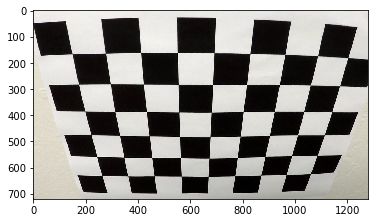

In [7]:
# Visualize the images 
image  = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(image)
plt.show()

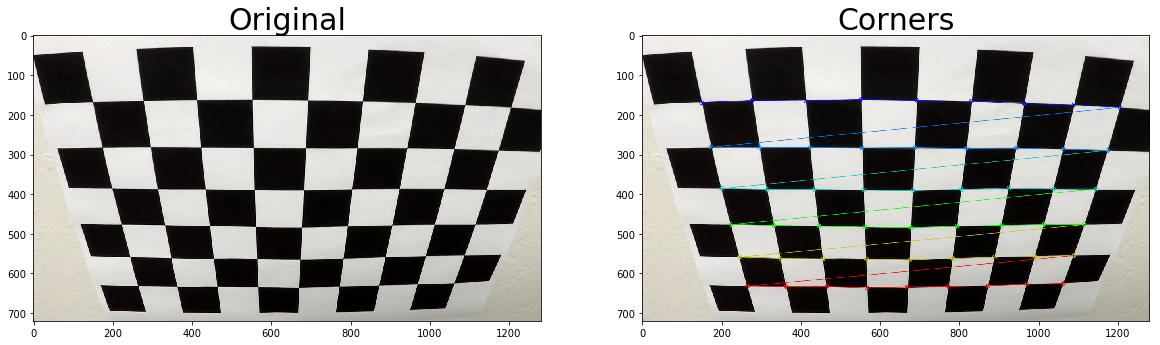

In [8]:
#  Calibrate the camera images  and find distortion  matrix and co-efficients
objpoints = []
imagepoints = []
images  = glob.glob('./camera_cal/calibration*.jpg')

# Lets  prepare object points for the  9x6 chessboard
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


# Read all the Calibrations images and get their corners 
for imgname  in images:
    image = mpimg.imread(imgname)
    beforeimage = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret ,corners = cv2.findChessboardCorners(gray,(9,6),None)
    


    if ret == True:
        imagepoints.append(corners)
        objpoints.append(objp)
        image  = cv2.drawChessboardCorners(image, (9,6),corners,ret)
        #print(imgname)
        # Plot a  single Corners image 
        if imgname =='./camera_cal\calibration2.jpg':
            plot(beforeimage, image , 'Original', 'Corners')
            
#plt.show()

# Use calibrate camera function to find the distortion matrix and co-efficents
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)


In [9]:
import pickle 
dictPoints = {'ObjPoints':[], 'ImgPoints':[]}
dictPoints['ObjPoints'] = objpoints
dictPoints['ImgPoints'] = imagepoints

with open('CalibrationPoints.pickle', 'wb') as handle:
    pickle.dump(dictPoints, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
# Read in the saved objpoints and imagepoints from the pickle file
distPickle = pickle.load( open( "CalibrationPoints.pickle", "rb" ) )
objPoints = distPickle["ObjPoints"]
imagePoints = distPickle["ImgPoints"]

In [11]:
def  UnDistort(image, objPoints , imagePoints):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, gray.shape[::-1], None, None)
    dst  = cv2.undistort(image ,mtx,dist,None,mtx)
    return dst
    

In [12]:
def combined_binary(image ,show=False):
    #img, Minv  = warp(image, show = False)
    s_channel = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]
    
        # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (s_binary ==1)] = 1
    
    if show:
        plot(image, s_channel, 'Original','S_Channel')
        plot(s_channel , s_binary, 'S_Channel' ,'S_Binary')
        plot(b_channel , b_binary, 'B_Channel' ,'B_Binary')
        plot(l_channel , l_binary, 'L_Channel' ,'L_Binary')
        plot(image , combined_binary, 'Original' ,'Combined Binary')
        
    
    return combined_binary

In [13]:
#  Define  Perspective transform 
def warp(image):
    image_size = (image.shape[1], image.shape[0])
    corners  = np.float32(
               [[180,720],
                [580,440],
                [700,440],
                [980,720]                
               ])
    offset = [130,0]
    top_left = np.array([corners[0,0],0])
    top_right = np.array([corners[3,0],0])
    #src = corners
    
    #dst = np.float32(
    #     [corners[0]+offset,
    #     top_left+offset,
    #     top_right-offset,
    #     corners[3]-offset              
    #      ])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    #dst = generatedst(image_size)
    M  = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped  = cv2.warpPerspective(image, M, image_size, flags= cv2.INTER_LINEAR)
    return warped ,Minv
    

In [14]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

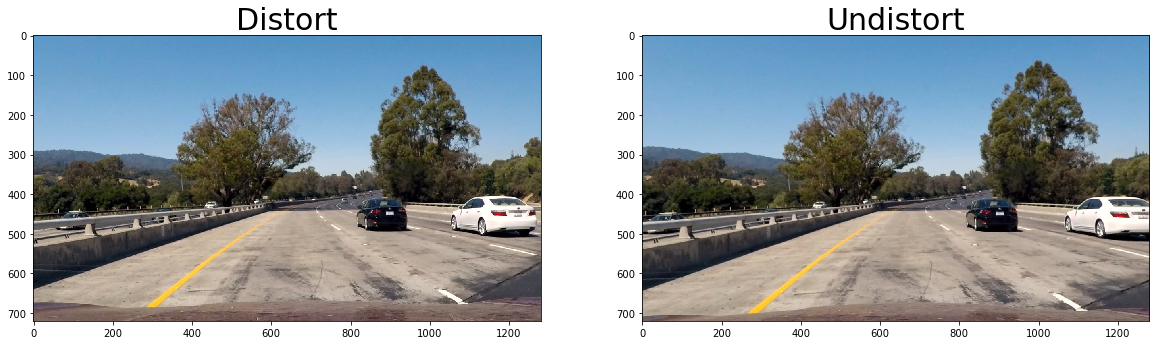

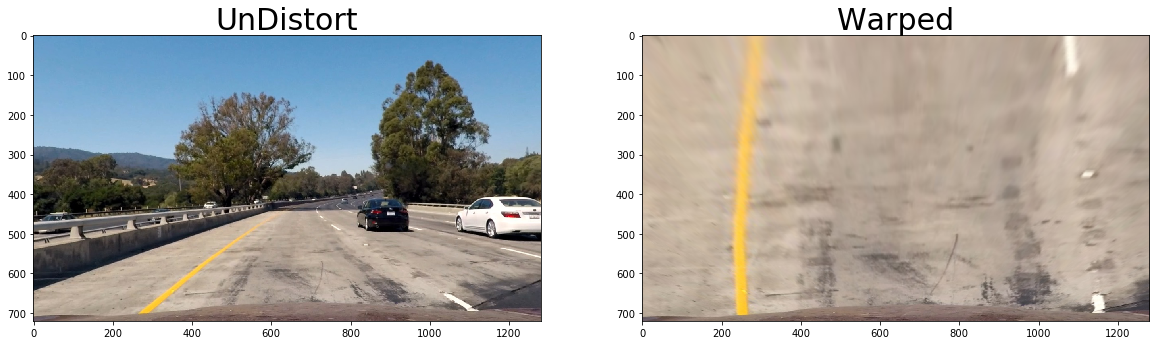

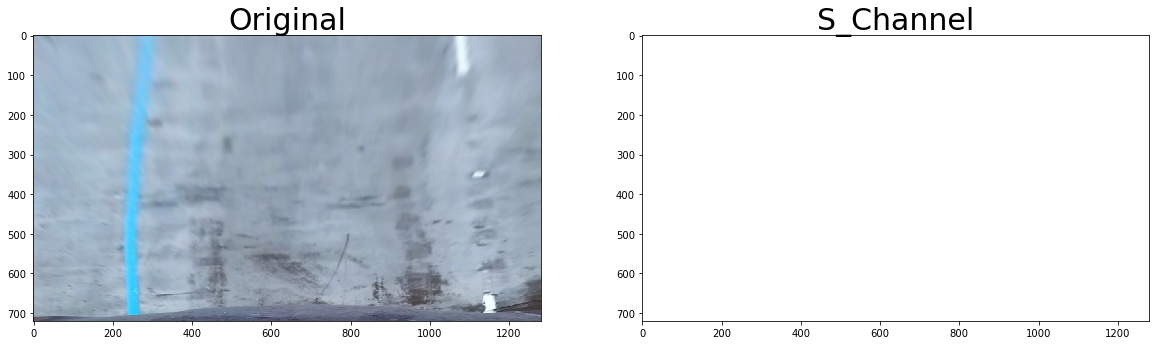

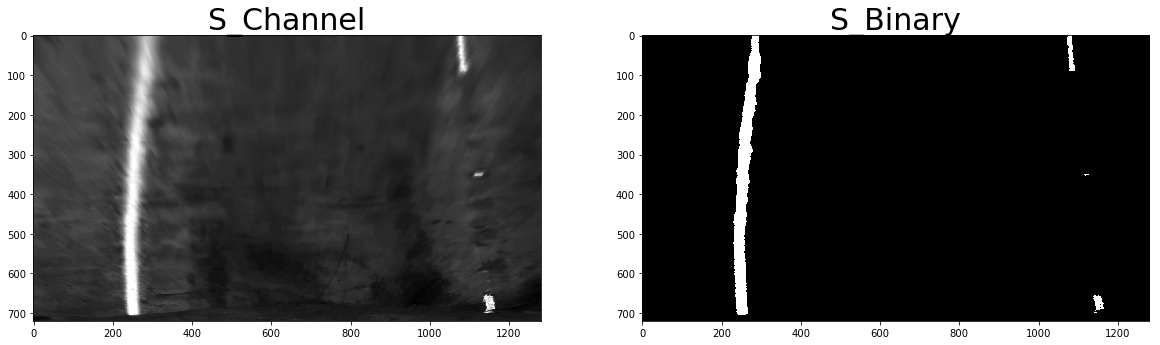

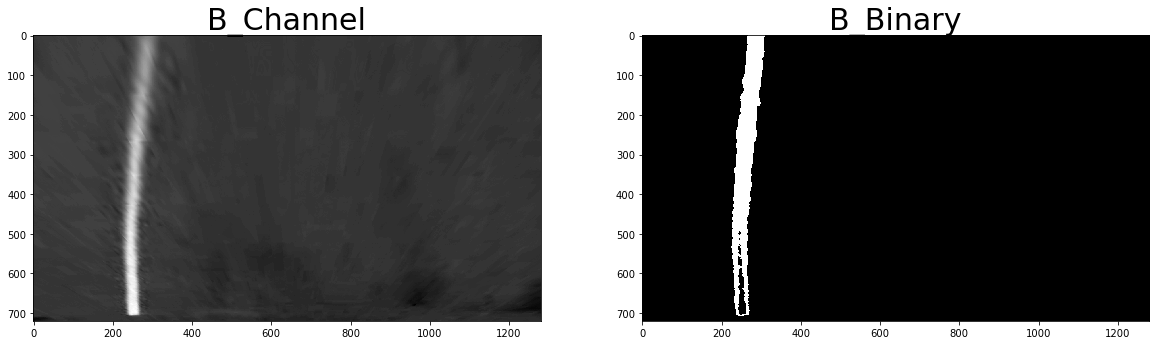

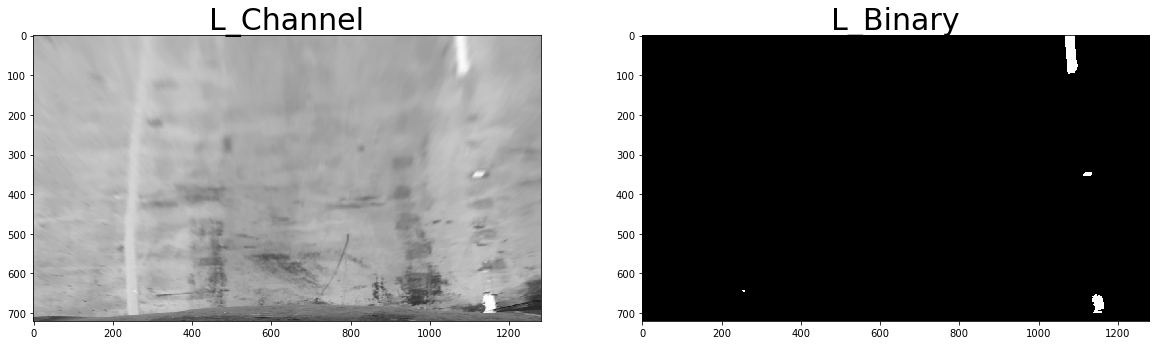

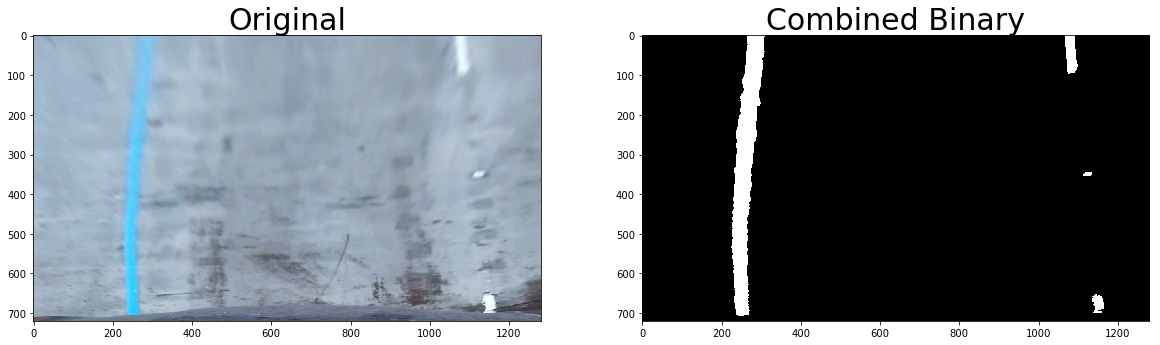

In [15]:
%matplotlib inline
#image = mpimg.imread('./signs_vehicles_xygrad.png')
#image  = cv2.imread('./signs_vehicles_xygrad.png')
image = cv2.imread('./test_images/test1.jpg')
undistort = UnDistort(image ,objPoints, imagePoints)
#image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#undistort  = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)
plot(image, undistort , 'Distort' ,'Undistort' , apply = True)
warped  = warp(undistort)[0]
plot(undistort,warped ,'UnDistort' ,'Warped' , apply = True)
binary_warped = combined_binary(warped,show=True)

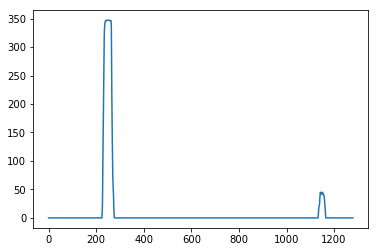

In [16]:
#print(combined_binary.shape)

histogram  = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis =0)
plt.plot(histogram)

In [17]:
left_peak = np.argmax(histogram[:640])

print(histogram[:640])

print(left_peak)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   6  15  40  92 129 168 206 242 282
 315 332 336 343 344 345 345 346 346 347 347 347 34

In [18]:
def fill_lanes(image):
    undistort = UnDistort(image ,objPoints, imagePoints)
    warped , Minv = warp(undistort)
    #plot(image, undistort , 'Distort' ,'Undistort')
    #binary_combined = combined_binaryEx(warped,X_gray_thresh=(20,100) ,S_color_thresh=(180,255),show=False)
    binary_combined = combined_binaryEx(warped)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x,y = np.nonzero(np.transpose(binary_combined))
    
    i = 720
    j = 630
    midpoint = image.shape[0]/2
    
    while j >= 0:
        histogram = np.sum(binary_combined[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:midpoint])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[midpoint:]) + midpoint
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
   
    #  Find the Raduis of Curvature
    left_roc = find_curvature(lefty , leftx)
    right_roc = find_curvature(righty, rightx)
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
   
    
    warp_zero = np.zeros_like(binary_combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_combined.shape[1], binary_combined.shape[0]))
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(BGR2RGB(warp(image)[0]))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(BGR2RGB(result))
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_roc + right_roc)/2)),
             style='italic', color='white', fontsize=10)
    
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)

    
    

In [19]:
for str in glob.glob('test_images/test*.jpg'):
    #print(str)
    image = cv2.imread(str)
    fill_lanes(image)

NameError: name 'combined_binaryEx' is not defined

In [35]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.top = None
        self.bottom =None
        
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
    
    def search(Self , x,y):
        xvals = []
        yvals = []
        
        if self.detected == False:
            height =720
            midpoint = 630
            while midpoint >= 0:
                histogram = np.sum(binary_combined[midpoint:height,:], axis=0)
                left_peak = np.argmax(histogram[:midpoint])
                x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > midpoint) & (y < height))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    leftx.extend(x_window.tolist())
                    lefty.extend(y_window.tolist())

                right_peak = np.argmax(histogram[midpoint:]) + midpoint
                x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > midpoint) & (y < height))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    rightx.extend(x_window.tolist())
                    righty.extend(y_window.tolist())
                height -= 90
                midpoint -= 90
                
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found

        
    def search_detected(self , x,y):
        xvals =[]
        yvals =[]
        
        if self.detected:
            height = 720
            midpoint = 630 # Image length/2
            while height >= 0:  #  We will  up to the top of the frame 
                yval = np.mean(height , midpoint)
                xvals = (np.mean(self.fit0)) *yval**2+(np.mean(self.fit1))*yval+(np.mean(self.fit2))
                x_idx = np.where(((xval-25) <x) & ( x< (xval+25)) & ((y > midpoint) & ( y < height)))
                x_window , y_window = x[x_idx] ,y[x_idx]
                if np.sum(x_window) !=0:
                    np.append(xvals,x_window)
                    np.append(yvals, y_window)
                height -= 90
                midpoint -=90
        if np.sum(xvals) ==0:
            self.detected = False
        
        return xvals,yvals, self.detected
                                 
        
    def find_curvature(self ,yvals, fitx):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(yvals)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def  sort(self , xvals, yvals):
        sorted_index  = np.argsort(yvals)
        sorted_xvals = xvals[sorted_index]
        sorted_yvals = yvals[sorted_index]
        return sorted_xvals , sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom  = polynomial[0]*720**2+ poylnomial[1]*720+polynomial[2];
        top = polynomial[2]
        return bottom , top


In [36]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    #undist = cv2.undistort(image, mtx, dist, None, mtx)
    undist = UnDistort(image , objPoints, imagePoints)
    warped ,Minv = warp(undist)
    binary_combined = combined_binary(warped)
    
 
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(binary_combined)) 

    if Left.detected == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.detected = Left.search_detected(x, y)
        
    if Right.detected == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.detected = Right.search_detected(x, y)

            
    if Right.detected == False: # Perform blind search for right lane lines
        rightx, righty, Right.detected = Right.search(x, y, binary_combined)
            
    if Left.detected == False:# Perform blind search for left lane lines
        leftx, lefty, Left.detected = Left.search(x, y, binary_combined)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    #Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [37]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))